<a href="https://colab.research.google.com/github/QuangTrongLeo/Animal_Identification_DL/blob/main/Animal_Identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("antoreepjana/animals-detection-images-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/animals-detection-images-dataset


In [20]:
# IMPORT
import os
import random
import keras
import torch
import torchvision

import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


# FROM
from glob import glob
from PIL import Image
from termcolor import colored
from torchvision import transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn


In [3]:
# Define train and test folders pathes.
train_dir = os.path.join(path, 'train')
test_dir = os.path.join(path, 'test')

## **Count and visualize the number of images in each class**

In [4]:
# Number of classes
classes = os.listdir(train_dir)
num_classes = len(classes)

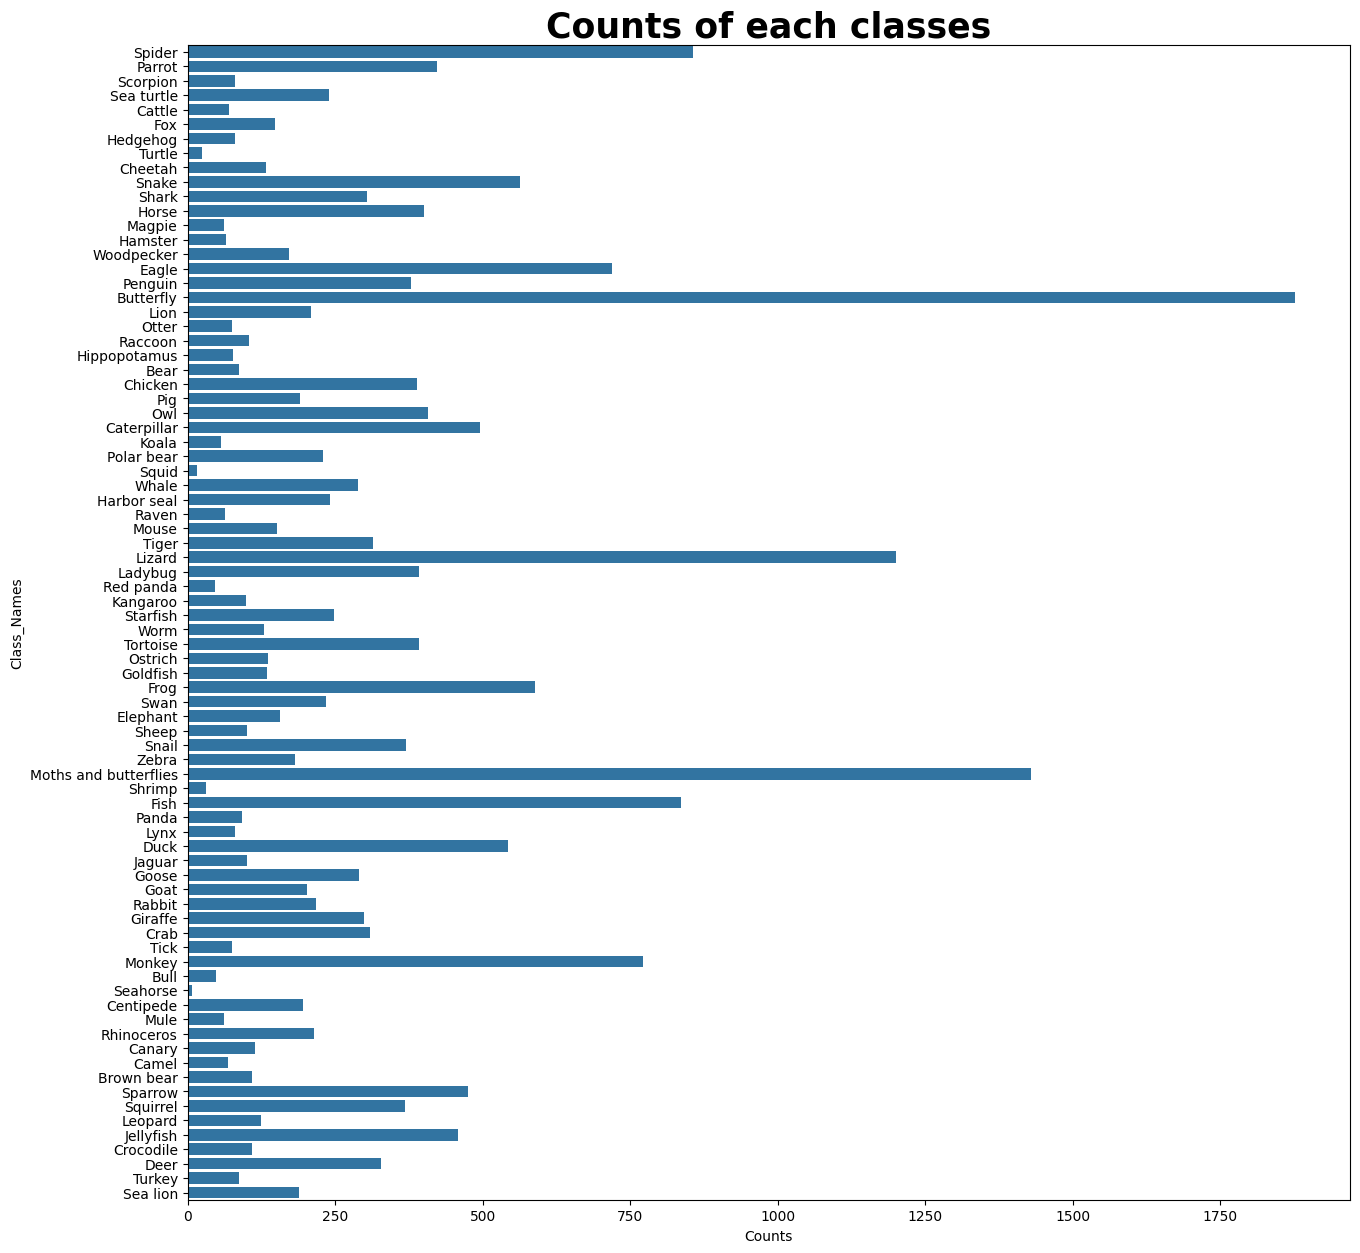

In [ ]:
# A variable to store number of images in each class and class names.
counts = []

# Loop over classes
for class_name in classes :
    class_path = os.path.join(train_dir, class_name)
    count = len(os.listdir(class_path))
    counts.append((class_name, count))

# Convert variable to DataFrame
counts = pd.DataFrame(counts, columns=['Class_Names', 'Counts'])

# Plot the DataFrame
plt.figure(figsize=(15, 15))
ax = sns.barplot(data=counts, y='Class_Names', x='Counts')
ax.set_title('Counts of each classes', fontsize=25, fontweight='bold')

plt.show()

## **Show 5 random animal images**

Total number of images found: 22566


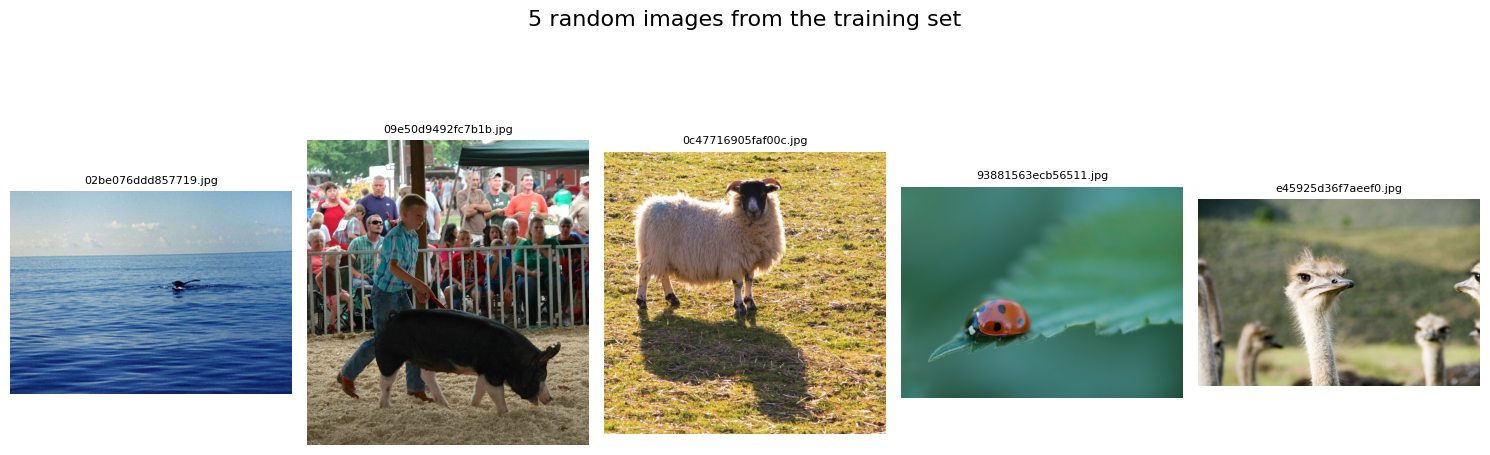

In [18]:
# Lấy tất cả ảnh từ các thư mục con
image_files = glob(os.path.join(train_dir, "**", "*.*"), recursive=True)
image_files = [f for f in image_files if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

# Random chọn 5 ảnh (hoặc ít hơn nếu không đủ)
num_images = min(5, len(image_files))
random_images = random.sample(image_files, num_images)
rows, cols = 1, 5

# Vẽ ảnh
fig, axes = plt.subplots(rows, cols, figsize=(15, 6))
fig.suptitle("5 random images from the training set", fontsize=16)

# Nếu chỉ có 1 hàng -> axes là 1D array
if cols == 1:
    axes = [axes]
elif rows == 1:
    axes = axes.flatten()

for i in range(num_images):
    img = mpimg.imread(random_images[i])
    axes[i].imshow(img)
    axes[i].set_title(os.path.basename(random_images[i]), fontsize=8)
    axes[i].axis('off')

# Ẩn ô thừa nếu < 5 ảnh
for i in range(num_images, rows * cols):
    axes[i].axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.99)
plt.show()

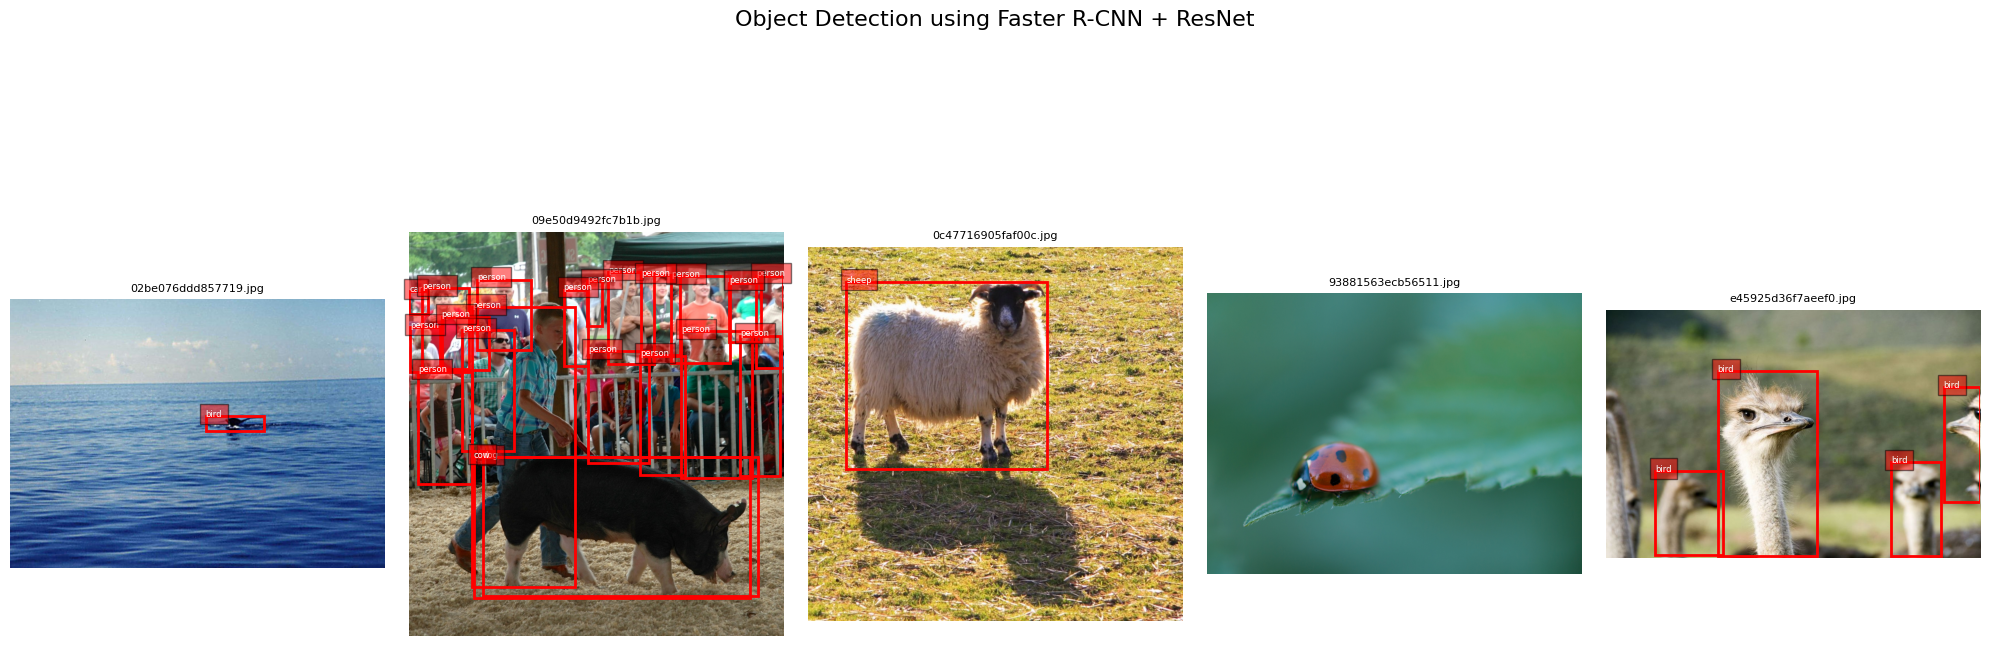

In [22]:
# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = fasterrcnn_resnet50_fpn(pretrained=True)
model.eval().to(device)

# from torchvision import transforms
# from PIL import Image

# Hàm dự đoán đối tượng trong ảnh
def get_predictions(img_path, threshold=0.7):
    image = Image.open(img_path).convert("RGB")
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    image_tensor = transform(image).to(device)
    with torch.no_grad():
        prediction = model([image_tensor])[0]

    boxes = prediction['boxes'].cpu()
    scores = prediction['scores'].cpu()
    labels = prediction['labels'].cpu()

    selected_boxes = boxes[scores > threshold]
    selected_labels = labels[scores > threshold]

    return image, selected_boxes, selected_labels

# Danh sách nhãn COCO
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A',
    'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard',
    'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard',
    'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife',
    'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot',
    'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
    'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

# Vẽ kết quả detection
rows, cols = 1, 5
fig, axes = plt.subplots(rows, cols, figsize=(20, 8))
fig.suptitle("Object Detection using Faster R-CNN + ResNet", fontsize=16)

if cols == 1:
    axes = [axes]
elif rows == 1:
    axes = axes.flatten()

for i in range(num_images):
    image_path = random_images[i]  # <--- DÙNG LẠI random_images từ CELL 1
    image, boxes, labels = get_predictions(image_path)

    axes[i].imshow(image)
    axes[i].set_title(os.path.basename(image_path), fontsize=8)
    axes[i].axis('off')

    for box, label in zip(boxes, labels):
        xmin, ymin, xmax, ymax = box
        axes[i].add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                        edgecolor='red', facecolor='none', linewidth=2))
        axes[i].text(xmin, ymin, COCO_INSTANCE_CATEGORY_NAMES[label],
                     bbox=dict(facecolor='red', alpha=0.5), fontsize=6, color='white')

for i in range(num_images, rows * cols):
    axes[i].axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()
